In [13]:
import numpy as np

import re 
from sklearn.metrics import classification_report,confusion_matrix

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from scipy import optimize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer
import string
from scipy.io import loadmat
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split

In [39]:
df = pd.read_csv('dataset.csv')
df['humor'] = df.humor.map({True:1,False:0})
df.head(2)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0


In [40]:
df.describe()

,humor
count,200000.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [41]:
df.groupby('humor').describe()

text                                                                
        count  unique                                                top freq
humor                                                                        
0      100000  100000  Joe biden rules out 2020 bid: 'guys, i'm not r...    1
1      100000  100000  What do you call a turtle without its shell? d...    1

In [42]:
df['length'] = df['text'].apply(len)
df.sort_values(by='length' ,ascending=False)


,text,humor,length
144836,'hunger games' box office win: film bests 'ame...,0,99
38526,An amnesiac knocks on the door knock knock. wh...,1,99
86508,Grammar is: 1. how we structure our sentences....,1,99
176930,What's the worst thing willie nelson can tell ...,1,99
67251,"Just overheard the phrase, pregnant with a bab...",1,99
...,...,...,...
49728,I love you to the moon and back,0,31
90893,A good we starts with a good me,0,31
199104,How to get your dog to sleep in,0,31
96776,My day as a working mom in gifs,0,31


array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

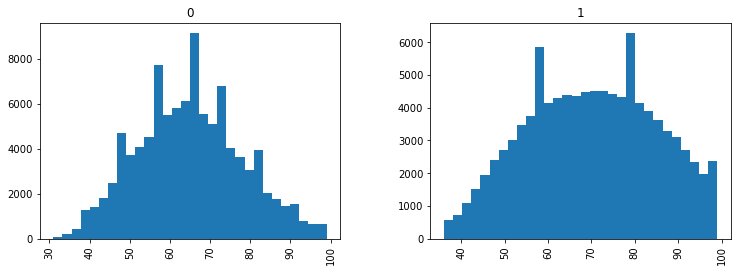

In [43]:
df.hist(column='length', by='humor', bins=30,figsize=(12,4))

## Text Pre-processing


In [44]:
def text_process(mess):
    
    stemmer = PorterStemmer() 

    nopunc = [char for char in mess if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    text_clean= [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return [stemmer.stem(word) for word in text_clean]

In [45]:
df['text'].head(5).apply(text_process)

0          [joe, biden, rule, 2020, bid, guy, im, run]
1    [watch, darvish, gave, hitter, whiplash, slow,...
2                  [call, turtl, without, shell, dead]
3               [5, reason, 2016, elect, feel, person]
4    [pasco, polic, shot, mexican, migrant, behind,...
Name: text, dtype: object

In [46]:
def build_freqs(text,label):
    freqs = {}
    for lab, text in zip(label, text):
        for word in text_process(text):
            pair = (word, lab)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

In [47]:
freqs = build_freqs(df['text'], df['humor'])
print(f'len(freqs) = {len(freqs)}')
print(freqs)


len(freqs) = 68955
{('joe', 0): 259, ('biden', 0): 154, ('rule', 0): 564, ('2020', 0): 39, ('bid', 0): 78, ('guy', 0): 343, ('im', 0): 348, ('run', 0): 581, ('watch', 0): 1152, ('darvish', 0): 1, ('gave', 0): 155, ('hitter', 0): 1, ('whiplash', 0): 4, ('slow', 0): 101, ('pitch', 0): 55, ('call', 1): 9890, ('turtl', 1): 93, ('without', 1): 562, ('shell', 1): 107, ('dead', 1): 794, ('5', 0): 1616, ('reason', 0): 785, ('2016', 0): 450, ('elect', 0): 794, ('feel', 0): 472, ('person', 0): 425, ('pasco', 0): 1, ('polic', 0): 988, ('shot', 0): 345, ('mexican', 0): 91, ('migrant', 0): 93, ('behind', 0): 391, ('new', 0): 4937, ('autopsi', 0): 16, ('show', 0): 2065, ('martha', 0): 45, ('stewart', 0): 154, ('tweet', 0): 487, ('hideou', 0): 5, ('food', 0): 1030, ('photo', 0): 6375, ('twitter', 0): 599, ('respond', 0): 224, ('accordingli', 0): 6, ('pokemon', 1): 177, ('master', 1): 92, ('favorit', 1): 1472, ('kind', 1): 988, ('pasta', 1): 102, ('wartortellini', 1): 1, ('nativ', 1): 97, ('american',

In [49]:
keys = ['bid', 'migrant', 'kind', 'climat', 'relationship', 'healthi', 'babi', 'favorit', 'elect',
        'found', 'syndrom', 'date', 'food', 'hate', 'photo', 'throw', 'coupl',
        'leader', 'surpris', 'oooooop', 'chose', 'video']
data = []
for word in keys:
    true=0
    false=0
    if (word, 1) in freqs:
        true = freqs[(word, 1)]
    if (word, 0) in freqs:
        false = freqs[(word, 0)]
    data.append([word, true, false])
    
data

[['bid', 7, 78],
 ['migrant', 2, 93],
 ['kind', 988, 181],
 ['climat', 17, 656],
 ['relationship', 269, 297],
 ['healthi', 59, 351],
 ['babi', 1162, 1035],
 ['favorit', 1472, 359],
 ['elect', 159, 794],
 ['found', 571, 455],
 ['syndrom', 58, 78],
 ['date', 644, 461],
 ['food', 728, 1030],
 ['hate', 1050, 319],
 ['photo', 91, 6375],
 ['throw', 345, 166],
 ['coupl', 178, 489],
 ['leader', 46, 455],
 ['surpris', 177, 437],
 ['oooooop', 1, 0],
 ['chose', 15, 20],
 ['video', 133, 3486]]

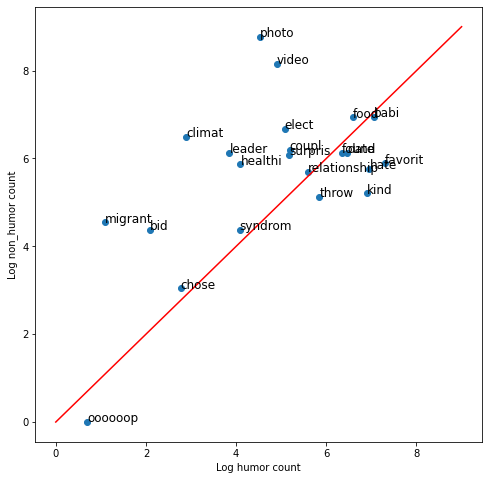

In [50]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log humor count")
plt.ylabel("Log non_humor count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()